# Questions for iClip

* Does SF3B1 (also) bind outside of 3' splice sites?
    * fraction of peaks / reads (e.g. crosslinks) in expressed 3' splice sites (~50-70 bases upstream) compared to fraction of the unspliced transcriptome (e.g. gene body regions).
    * others: background noise or signal?
    * what is the fraction of reads falling into peaks?
    * estimate enrichment of signal over background / noise? ~ 10 fold? 
        * Same for all samples, or different?
    * size of background: 692,940,528 bases (combined gene bodies of genes >10 reads)
    * size of foreground: 100,000 x 20 x 2 (number of introns x peak width x number of peaks per profile) -> less than 1%
* Due to many putative binding sites at 3' splice sites, its challenging to identify individual sites (e.g. by peak calling)
    * putative target: 
        * (conservative estimate) 45.000 3' splice sites covered by > 100 long reads in K562 samples (wt+mut)
        * \>100,000  covered by > 10 long reads in K562 samples (wt+mut)
        * (upper limit) ~ 432.000 from Gencode
    * 70 M reads -> sufficient coverage to see peaks? 
    * to see double peak > 20 iClIP reads?
    * depends on assumptions and fraction of background reads (enrichment fractor)
* Differential binding wt vs mut
    * No major effect (FC>2)
    * Potentially small effect FC ~ 1%?
    * Individual sites impossible at this effect size, but meta profiles?
    * Normalization (background) becomes crucial!
    * Which peak is different, in what direction?
* Significance of double peak: relation to U2AF2 binding / assembly process
    * proximal peak overlaps U2AF peak (polyY)
    * still both peaks mean DIRECT SF3B1 binding?
    * Is it somehow related to assembly process?
        * e.g. SF3B1 binds branchpoint (distal peak) first, then polyY (proximal peak) after removal of U2AF
* Clustering approach:
    * What is the explanation for the different clusters? Noise?
    * Large double peak cluster: Subcluster peak distance correlate with branchpoint distance?


## literature
* mut SF3B1 alters binding (ESRRG): (Li, NatCom 2020)[https://www.nature.com/articles/s41467-020-16052-8]
* U2 binding affinity is important for aberrant splicing NatCom 20146: https://www.nature.com/articles/ncomms10615

In [1]:
import logging
import os
import pandas as pd
import numpy as np
from glob import glob
from pysam import FastaFile
from Bio.Seq import Seq
import pyBigWig

import matplotlib.pyplot as plt
import pathlib
from  isotools import Transcriptome
from isotools._utils import pairwise
from tqdm import tqdm
import isotools
logger=logging.getLogger('isotools')
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)
logger.info(f'This is isotools version {isotools.__version__}')


INFO:This is isotools version 0.3.3


In [2]:
path='/project/42/pacbio/golong'
date='2022_12'
project='golong_all'
out_path=f'{path}/06-isotools/{project}/results_{date}'
table_path=f'{out_path}/08_iCLIP/tables'
plot_path=f'{out_path}/08_iCLIP/plots'
pathlib.Path(plot_path).mkdir(parents=True, exist_ok=True)
pathlib.Path(table_path).mkdir(parents=True, exist_ok=True)

ref_fn=f'{path}/../references/gencode/gencode.v36.chr_patch_hapl_scaff.annotation_sorted'
genome_fn=f'{path}/../references/gencode/GRCh38.p13.genome.fa'

In [3]:
group_colors={'CLL_mut':'#B2182B', 'CLL_wt':'#2166AC', 'MDS_mut':'#EF8A62', 'MDS_wt':'#67A9CF','CL_mut':'#FDDBC7' ,'CL_wt':'#D1E5F0','B-cell':'#543005','GM12878_ENCODE':'#A6611A', 'other':'#018571'}
group_colors['all_mut']=group_colors['MDS_mut']
group_colors['all_wt']=group_colors['MDS_wt']
group_colors['reference']=group_colors['other']


# iClip results
## all introns

In [4]:
introns=pd.read_csv(f'{out_path}/07_branchpoint_prediction/tables/introns_K562_branchpoints_th10_18bp.csv')
# else:
#    introns=pd.read_csv('/project/42/pacbio/golong/06-isotools/golong_all/tables/golong_all_2021_11_K562_introns_svm_bpfinder_best.csv')
#    introns=introns.rename(columns=lambda x: {"ss_dist": "bpdist"}.get(x, x))

In [5]:
#outpaths to be changed

In [6]:
cov={}
for sa in ['mut_1','mut_3','wt_2','wt_3','wt_4']:  
    cov[sa]=0
    for strand in ('Plus','Minus'):
        bw=pyBigWig.open(f'{path}/iCLIP/data/subsampled_bigwig/{sa}_subs.coverage{strand}.bw')        
        cov[sa]+=bw.header()['sumData']
        bw.close()
    print(f"{sa}: {cov[sa]}")
print(f'total: {sum(cov.values())}')

mut_1: 13840455
mut_3: 13849887
wt_2: 13753821
wt_3: 13826605
wt_4: 13571799
total: 68842567


In [7]:

#get the iclip profiles for the introns
total=len(introns)
print(total)
bw={'wt':{'+':{},'-':{}},'mut':{'+':{},'-':{}}}
flanking=200
for sa in ['mut_1','mut_3','wt_2','wt_3','wt_4']:
    g=sa[:sa.find('_')]
    bw[g]['+'][sa]=pyBigWig.open(f'{path}/iCLIP/data/subsampled_bigwig/{sa}_subs.coveragePlus.bw')
    bw[g]['-'][sa]=pyBigWig.open(f'{path}/iCLIP/data/subsampled_bigwig/{sa}_subs.coverageMinus.bw')
iclip_bw={align:{'wt':[],'mut':[]} for align in ['3AS', 'BP_branchpointeR']}#,'BP_PWM','BP_UNAY']}
bpdist={k:[] for k in iclip_bw if k[:2]=="BP"}
for i,row in tqdm(introns.iterrows(), total=total):
    if row.chrom not in bw['mut']['+']['mut_1'].chroms():
        continue
    for align in iclip_bw:
        if align=='3AS':
            pos=row.start if row.strand=='-' else row.end
        elif align == 'BP_branchpointeR':
            bpdist[align].append(row.bpdist)
            pos=row.start+row.bpdist if row.strand=='-' else row.end-row.bpdist
        else:
            bp_d=min(row[align]) if row[align] else 100
            bpdist[align].append(bp_d)
            pos=row.start+bp_d if row.strand=='-' else row.end-bp_d
            
        for g in iclip_bw[align]:
            profile=np.zeros(2*flanking)
            for bwi in bw[g][row.strand].values():
                profile+=np.nan_to_num(bwi.values(row.chrom, pos-flanking, pos+flanking))
            if row.strand=='+':
                iclip_bw[align][g].append(profile)
            else:
                iclip_bw[align][g].append(np.flip(profile))
        
for align in iclip_bw:        
    for g in iclip_bw[align]:
        iclip_bw[align][g]=pd.DataFrame(iclip_bw[align][g], columns=[i for i in range(-flanking, flanking+1) if i!=0])
    iclip_bw[align]['all']=iclip_bw[align]['wt']+iclip_bw[align]['mut']

for gd in bw.values():
    for gds in gd.values():
        for gdss in gds.values():
            gdss.close()


100987


100%|██████████| 100987/100987 [03:49<00:00, 439.44it/s]


In [8]:
for k,df in iclip_bw['BP_branchpointeR'].items():
    within=df.values[:,120:250].sum()
    outside=df.values[:,260:390].sum()
    total=sum(sacov for sa,sacov in cov.items() if k in sa or k=='all' )
    print(f'{k}: {within} ({within/total:.2%})')
    print(f'{k}: {outside} ({outside/total:.2%})')

wt: 11992245.0 (29.14%)
wt: 5316882.0 (12.92%)
mut: 8548519.0 (30.87%)
mut: 3611450.0 (13.04%)
all: 20540764.0 (29.84%)
all: 8928332.0 (12.97%)


In [9]:


# import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm
xrange=[-100,100]
#cmap = cm.get_cmap('jet', 30)
cmap = cm.get_cmap('viridis', 30)

In [10]:
genome_fn=f'{path}/../references/gencode/GRCh38.p13.genome.fa'
flank=[-400,400]
base={b:i for i,b in enumerate("ACGT")}
base_count={align:np.zeros((5,flank[1]-flank[0]), int) for align in iclip_bw}
with FastaFile(genome_fn) as genome_fh:
    for i,row in tqdm(introns.iterrows(), total=len(introns)):         
        shifts={'3AS':0, 'BP_branchpointeR':row.bpdist}
        #shifts['BP_PWM']=min(row['BP_PWM']) if row['BP_PWM'] else 100
        #shifts['BP_UNAY']=min(row['BP_UNAY']) if row['BP_UNAY'] else 100
        seq={}
        if row.strand=='+':
            pos=row.end
            for align in shifts:
                seq[align]=str(Seq(genome_fh.fetch(row.chrom, pos+flank[0]-1-shifts[align],pos+flank[1]-1-shifts[align])))
        else:
            pos=row.start
            for align in shifts:
                seq[align]=str(Seq(genome_fh.fetch(row.chrom, pos-flank[1]+1+shifts[align],pos-flank[0]+1+shifts[align])).reverse_complement())
        for align in seq:
            for i,b in enumerate(seq[align]):
                base_count[align][base.get(b,4),i]+=1
for k in base_count:
    base_count[k]=pd.DataFrame(base_count[k], columns=range(*flank), index=list('ACGTN') )

100%|██████████| 100987/100987 [02:53<00:00, 583.59it/s]


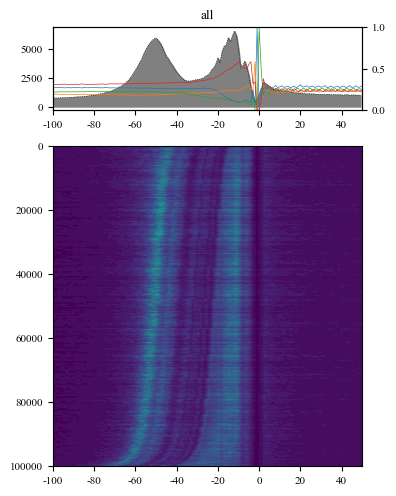

In [15]:
tool='branchpointeR'
plt.rcParams['axes.unicode_minus']=False
plt.rcParams["font.size"]=8
plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["figure.figsize"] = (4,5)
xlim=[-100,50]
peak_range=[-100,0]
peak_width=20
n_sa={'all':5, 'wt':3, 'mut':2}
#norm_method='raw' 
norm_method='normalized'
#xlim=-15,5
align='3AS'
what='all'
fig = plt.figure()
sel=iclip_bw[align]['all'].sum(1)>0

dists=[(i,d) for i,(s,d) in enumerate(zip(sel,bpdist.get(align, bpdist['BP_branchpointeR']))) if s]
order=[i for i,_ in sorted(dists, key=lambda x: x[1])]
#vals=iclip_bw[align][what].values[sel,slice(flanking+xlim[0], flanking+xlim[1])]
vals=iclip_bw[align][what].loc[order,slice(xlim[0], xlim[1])].values/n_sa[what]
if norm_method!='raw':
    vals/=np.maximum(np.max(vals, axis=1),10)[:,None]
#vals[vals>1]=1
ax_profile = plt.subplot2grid((4,1), (0,0), colspan=1, rowspan=1, fig=fig)
y=vals.sum(0)
x=range(*xlim)
ax_profile.plot( x,y,ls=':', color='black', lw=.5)
ax_profile.fill_between(x, y, color='grey')
ax_profile.set_xlim(*xlim)
ax = plt.subplot2grid((4,1), (1,0), colspan=1, rowspan=3, fig=fig)

im=ax.imshow(vals,norm=colors.Normalize(vmin=0, vmax=.2), cmap=cmap, 
                 aspect='auto',  interpolation='gaussian',extent=[*xlim,len(vals),0])
ax_profile.set_title(what)
ax_base = ax_profile.twinx()
x=range(*xrange)
base_profile=base_count[align][range(*xrange)]/ base_count[align][range(*xrange)].sum(0)
for base in 'ACGT':
    ax_base.plot(x, base_profile.loc[base], label=base, lw=.5)
ax_base.set_ylim(0,1)

fig.tight_layout()
fig.savefig(f"{plot_path}/iCLIP_heatmap_introns_fwd_{align}_{norm_method}_{tool}_all.pdf")


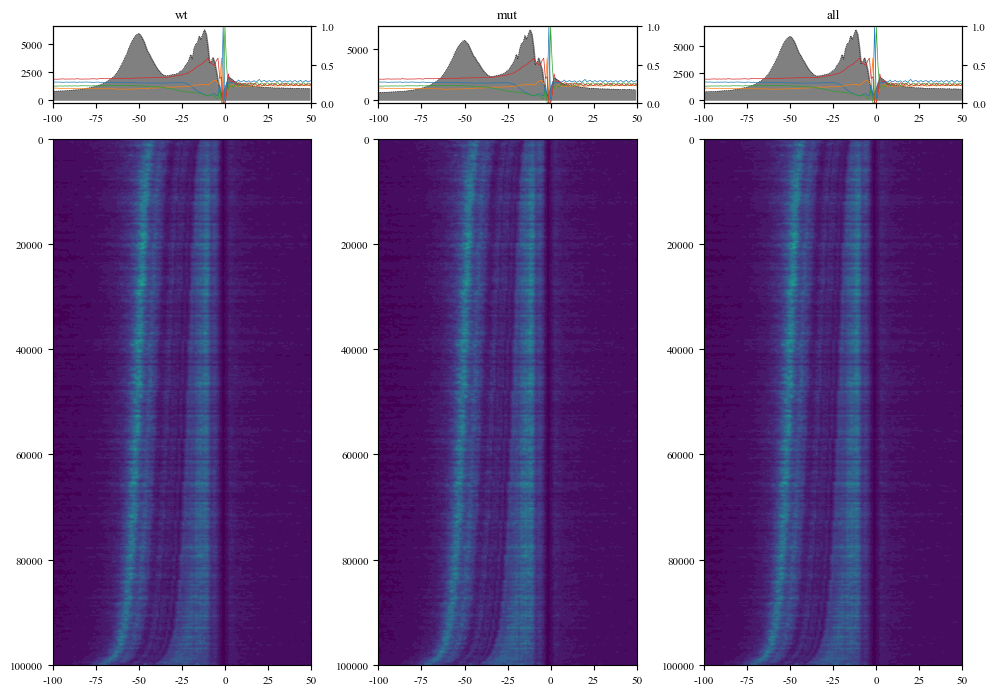

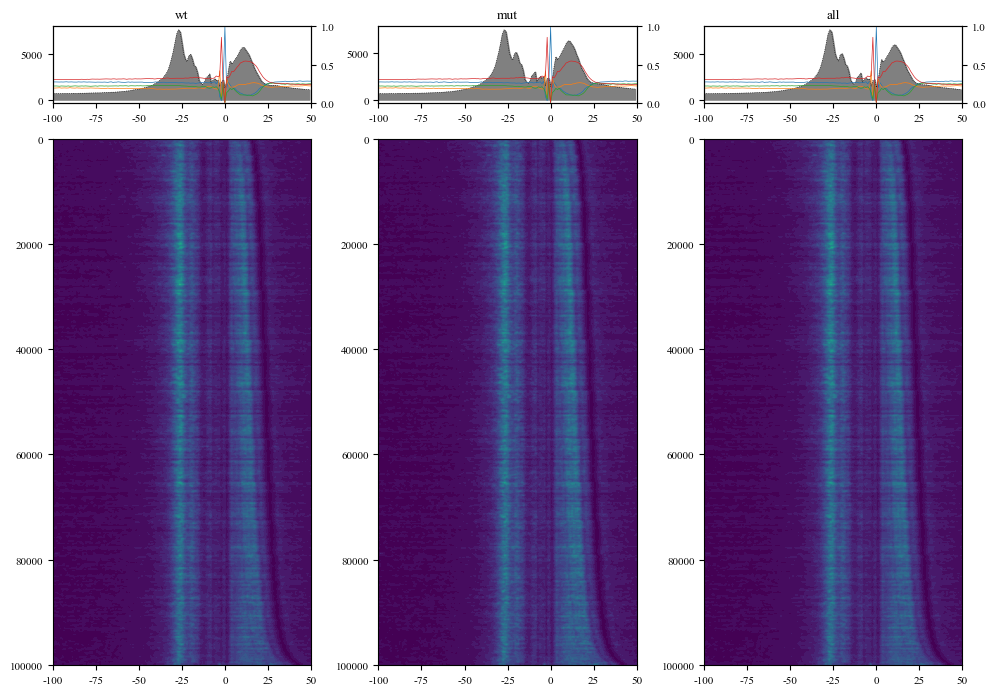

In [16]:
plt.rcParams["figure.figsize"] = (10,7)
xlim=[-100,50]
peak_range=[-100,0]
peak_width=20
n_sa={'all':5, 'wt':3, 'mut':2}
#norm_method='raw' 
norm_method='normalized'
#xlim=-15,5

for align in iclip_bw:
    fig = plt.figure()
    sel=iclip_bw[align]['all'].sum(1)>0
    
    dists=[(i,d) for i,(s,d) in enumerate(zip(sel,bpdist.get(align, bpdist['BP_branchpointeR']))) if s]
    order=[i for i,_ in sorted(dists, key=lambda x: x[1])]
    for i,what in enumerate(iclip_bw[align]):
        #vals=iclip_bw[align][what].values[sel,slice(flanking+xlim[0], flanking+xlim[1])]
        vals=iclip_bw[align][what].loc[order,slice(xlim[0], xlim[1])].values/n_sa[what]
        if norm_method!='raw':
            vals/=np.maximum(np.max(vals, axis=1),10)[:,None]

        #vals[vals>1]=1
        ax_profile = plt.subplot2grid((6,3), (0,i), colspan=1, rowspan=1, fig=fig)
        y=vals.sum(0)
        x=range(*xlim)
        ax_profile.plot( x,y,ls=':', color='black', lw=.5)
        ax_profile.fill_between(x, y, color='grey')
        ax_profile.set_xlim(*xlim)
        ax = plt.subplot2grid((6,3), (1,i), colspan=1, rowspan=5, fig=fig)

        im=ax.imshow(vals,norm=colors.Normalize(vmin=0, vmax=.2), cmap=cmap, 
                         aspect='auto',  interpolation='gaussian',extent=[*xlim,len(vals),0])
        ax_profile.set_title(what)
        ax_base = ax_profile.twinx()
        x=range(*xrange)
        base_profile=base_count[align][range(*xrange)]/ base_count[align][range(*xrange)].sum(0)
        for base in 'ACGT':
            ax_base.plot(x, base_profile.loc[base], label=base, lw=.5)
        ax_base.set_ylim(0,1)
        #ax_base.legend()
    #fig.colorbar(im, ax=axs[2])
    #extent=[-400,400,n-offset,0]
    fig.tight_layout()
    fig.savefig(f"{plot_path}/iCLIP_heatmap_introns_fwd_{align}_{norm_method}_{tool}.pdf")


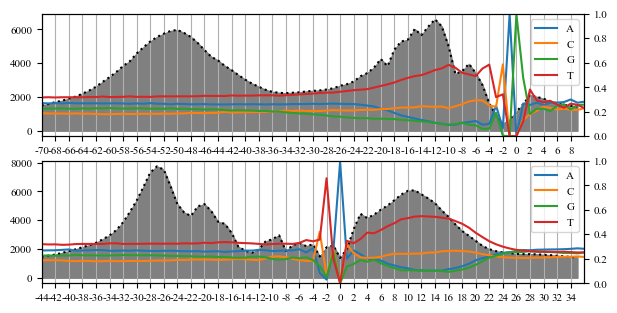

In [150]:
plt.rcParams["figure.figsize"] = (7,3.5)
xlim={'3AS':(-70,10),'BP_branchpointeR':(-44,36)}
fig,axs=plt.subplots(2)
for ax,align in zip (axs, iclip_bw):
    vals=iclip_bw[align]['all'].values[sel,slice(flanking+xlim[align][0], flanking+xlim[align][1])]/n_sa[what]
    if norm_method!='raw':
        vals/=np.maximum(np.max(vals, axis=1),10)[:,None]
    y=vals.sum(0)
    x=range(*xlim[align])
    ax.plot( x,y,ls=':', color='black')
    ax.fill_between(x, y, color='grey')
    ax.set_xlim(*xlim[align])
    ax.set_xticks(range(*xlim[align],2))
    ax.grid(axis='x',which='both')
    ax_base = ax.twinx()
    x=range(*xrange)
    base_profile=base_count[align][range(*xrange)]/ base_count[align][range(*xrange)].sum(0)
    for base in 'ACGT':
        ax_base.plot(x, base_profile.loc[base], label=base)
    ax_base.set_ylim(0,1)
    ax_base.legend()
fig.savefig(f"{plot_path}/iCLIP_profiles_introns_{norm_method}_{tool}.pdf")

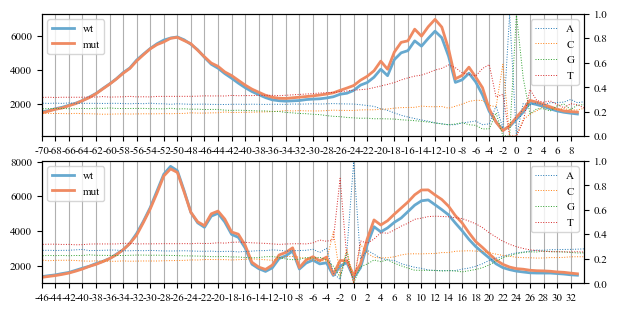

In [18]:

plt.rcParams["figure.figsize"] = (7,3.5)
xlim={'3AS':(-70,10),'BP':(-46,34)}
n_sa={'wt':3, 'mut':2}
pvals={}
fig,axs=plt.subplots(2)
for ax,align in zip (axs, iclip_bw):
    xlim_i=xlim[align.split('_')[0]]
    for what in ['wt', 'mut']:
        vals=iclip_bw[align][what].values[sel,slice(flanking+xlim_i[0], flanking+xlim_i[1])]/n_sa[what]
        if norm_method!='raw':
            vals/=np.maximum(np.max(vals, axis=1),10)[:,None]
        y=vals.sum(0)
        x=range(*xlim_i)
        ax.plot( x,y,ls='-', color=group_colors['all_'+what], lw=2, label=what)
    #ax.fill_between(x, y, color='grey')
    ax.set_xlim(*xlim_i)
    ax.set_xticks(range(*xlim_i,2))
    ax.grid(axis='x',which='both')
    ax.legend(loc='upper left')
    ax_base = ax.twinx()
    x=range(*xrange)
    base_profile=base_count[align][range(*xrange)]/ base_count[align][range(*xrange)].sum(0)
    for base in 'ACGT':
        ax_base.plot(x, base_profile.loc[base], label=base,ls=':', lw=.7)
    ax_base.set_ylim(0,1)
    ax_base.legend(loc='upper right')
fig.savefig(f"{plot_path}/iCLIP_profiles_introns_mut_wt_{norm_method}_{tool}.pdf")

In [19]:
# is there a difference between the wt/mut profiles 
from scipy.stats import fisher_exact,chisquare
#peaks={'3AS':((-58,-44),(-20,-6)), 'BP':((-32,-18),(3,17))}
peaks={'3AS':((-50,-49),(-12,-11)), 'BP_branchpointeR':((-27,-26),(10,11))}
res={}
for align in iclip_bw:
    xlim_i=xlim[align.split('_')[0]]
    print(align)
    y={}
    for what in ['wt', 'mut']:
        vals=iclip_bw[align][what].values[sel,slice(flanking+xlim_i[0], flanking+xlim_i[1])]
        y[what]=vals.sum(0)
    y=pd.DataFrame(y, index=range(*xlim_i))
    sum_wt=y['wt'].sum()
    sum_mut=y['wt'].sum()
    sum_total=sum_wt+sum_mut
    mat=[list(y.loc[range(*peaks[align][i])].sum(0)) for i in range(2)]
    res[align]=fisher_exact(mat)
    
res        

3AS
BP_branchpointeR


{'3AS': (1.11070884627789, 8.343604961786037e-126),
 'BP_branchpointeR': (1.1230008520346186, 1.1247628002880147e-165)}

## 3'AS events

In [20]:
samples=pd.read_csv(f'{out_path}/01_transcriptome/{project}_{date}_samples.csv').set_index('name')
groups={grpn:samples.index[samples.group==grpn].tolist() for grpn in set(samples.group)}
group_dict={sa:gn for gn,sa_list in groups.items() for sa in sa_list}
group_num={sa:i for i,sa in enumerate(['K562_mut','K562_wt','Nalm6_mut', 'Nalm6_wt','CLL_mut','CLL_wt', 'MDS_mut', 'MDS_wt','B-cell'])}



In [21]:
import pyBigWig

#get the iclip profiles for the 3AS events
res_3as=pd.read_csv(f'{out_path}/07_branchpoint_prediction/tables/golong_all_2022_12_diff_3AS_all_branchpointer.csv')
res_3as=res_3as.query("AS_shift>-100 and AS_shift<100").sort_values("AS_shift")

total=len(res_3as)
print(total)
bw={'wt':{'+':{},'-':{}},'mut':{'+':{},'-':{}}}
flanking=200
for sa in ['mut_1','mut_3','wt_2','wt_3','wt_4']:
    g=sa[:sa.find('_')]
    bw[g]['+'][sa]=pyBigWig.open(f'{path}/iCLIP/data/subsampled_bigwig/{sa}_subs.coveragePlus.bw')
    bw[g]['-'][sa]=pyBigWig.open(f'{path}/iCLIP/data/subsampled_bigwig/{sa}_subs.coverageMinus.bw')
iclip_bw={align:{'wt':[],'mut':[]} for align in ['3AS', 'BP_branchpointeR']}#,'BP_PWM','BP_UNAY']}
bpdist={k:[] for k in iclip_bw if k[:2]=="BP"}
for i,row in tqdm(res_3as.iterrows(), total=total):
    if row.chrom not in bw['mut']['+']['mut_1'].chroms():
        continue
    for align in iclip_bw:
        if align=='3AS':
            if row.all_wt_PSI>row.all_mut_PSI:
                pos=row.alternative
            elif row.strand=='-':
                pos=row.start
            else:
                pos=row.end
        elif align == 'BP_branchpointeR':
            if row.all_wt_PSI>row.all_mut_PSI:
                bp_d=row.bpdist_alt  
                pos=row.alternative+bp_d if row.strand=='-' else row.alternative-bp_d
            else:
                bp_d=row.bpdist
                pos=row.start+bp_d if row.strand=='-' else row.end-bp_d
            bpdist[align].append(bp_d)
            
        else:
            bp_d=min(row[align]) if row[align] else 100
            bpdist[align].append(bp_d)
            pos=row.start+bp_d if row.strand=='-' else row.end-bp_d
            
        for g in iclip_bw[align]:
            profile=np.zeros(2*flanking)
            for bwi in bw[g][row.strand].values():
                profile+=np.nan_to_num(bwi.values(row.chrom, pos-flanking, pos+flanking))
            if row.strand=='+':
                iclip_bw[align][g].append(profile)
            else:
                iclip_bw[align][g].append(np.flip(profile))
        
for align in iclip_bw:        
    for g in iclip_bw[align]:
        iclip_bw[align][g]=pd.DataFrame(iclip_bw[align][g], columns=[i for i in range(-flanking, flanking+1) if i!=0])
    iclip_bw[align]['all']=iclip_bw[align]['wt']+iclip_bw[align]['mut']

for gd in bw.values():
    for gds in gd.values():
        for gdss in gds.values():
            gdss.close()

iclip_bw_sig={a:{gr:df.loc[(res_3as.padj<.1).values] for gr,df in iclip_bw[a].items()} for a in iclip_bw}
iclip_bw_notsig={a:{gr:df.loc[(res_3as.padj>=.1).values] for gr,df in iclip_bw[a].items()} for a in iclip_bw}
iclip_bw_dict={'all':iclip_bw,'sig':iclip_bw_sig,'notsig':iclip_bw_notsig}

4467


100%|██████████| 4467/4467 [00:09<00:00, 450.58it/s]


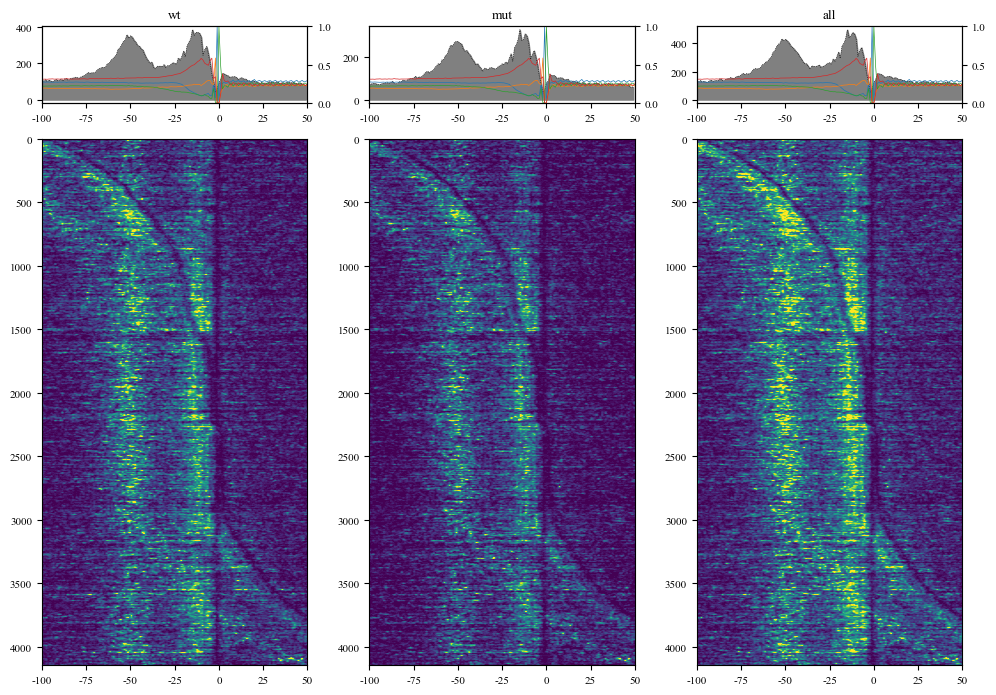

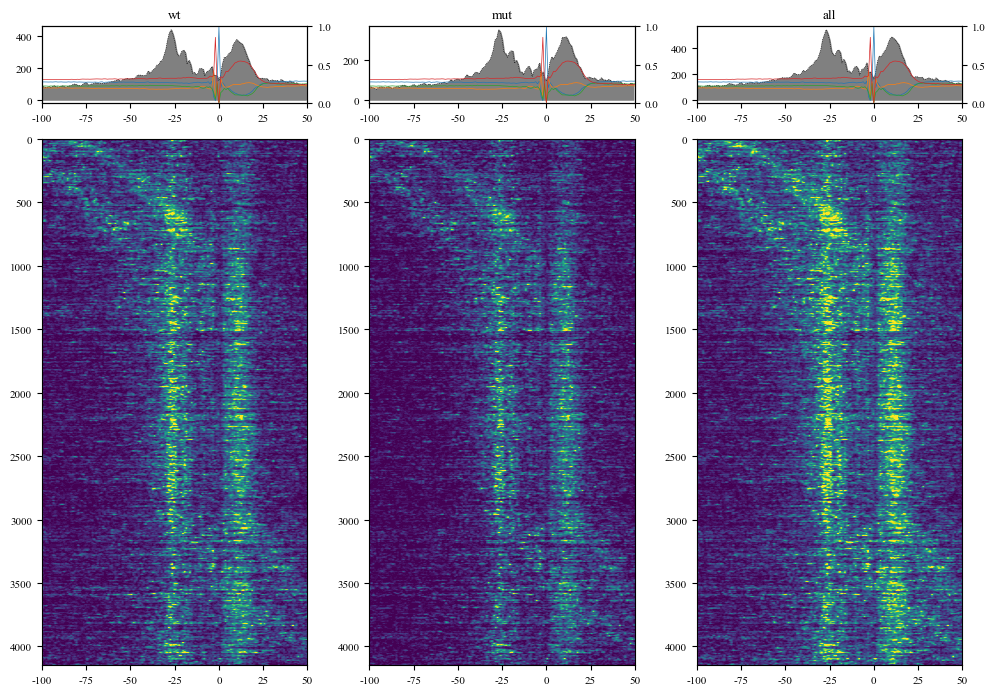

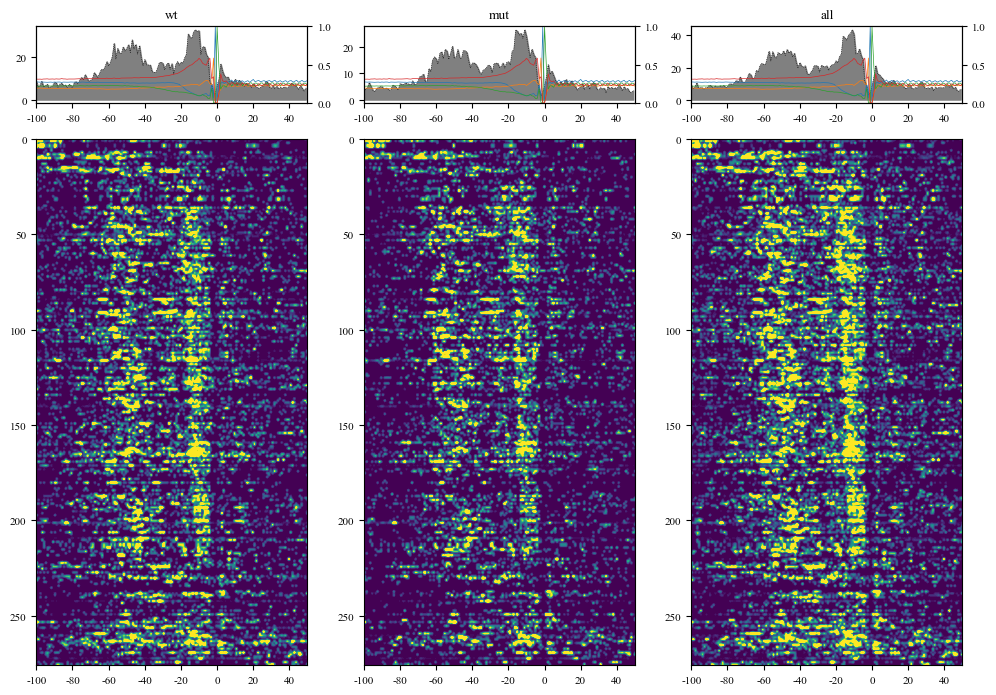

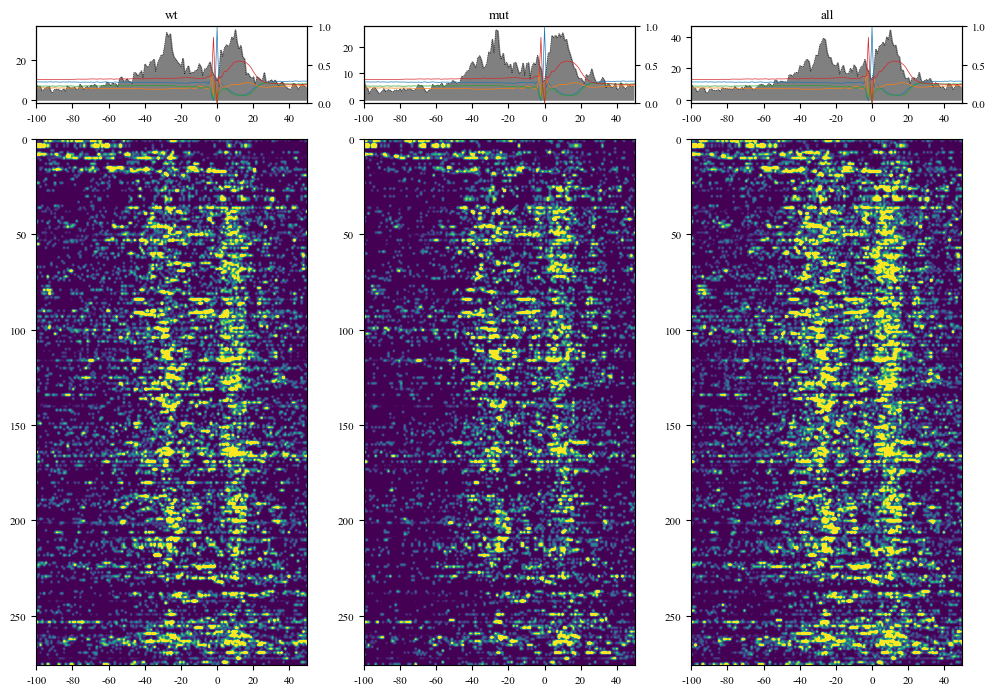

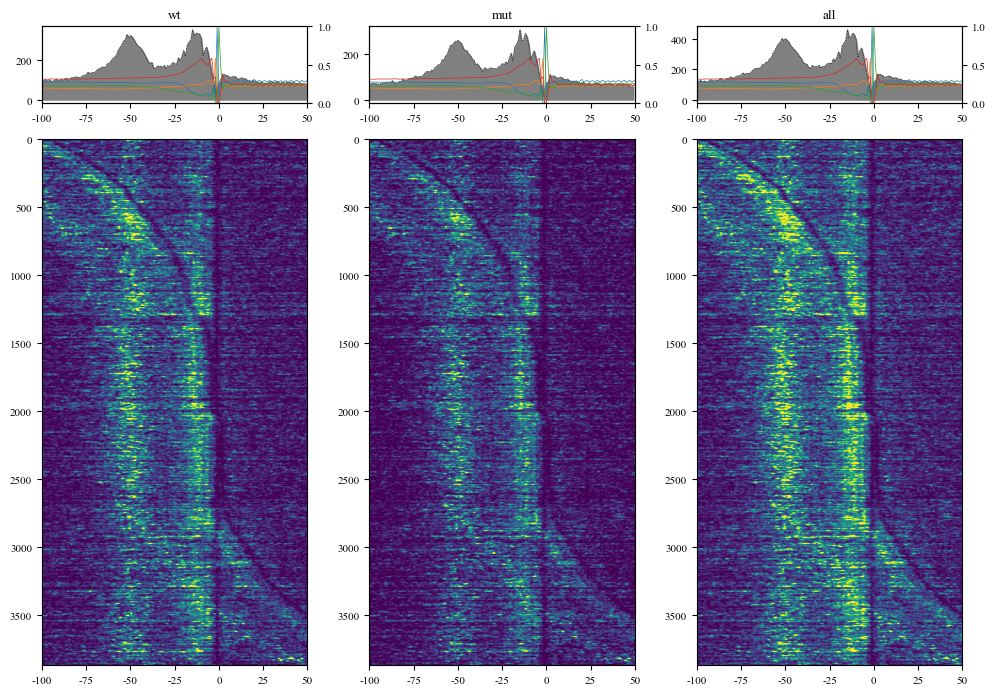

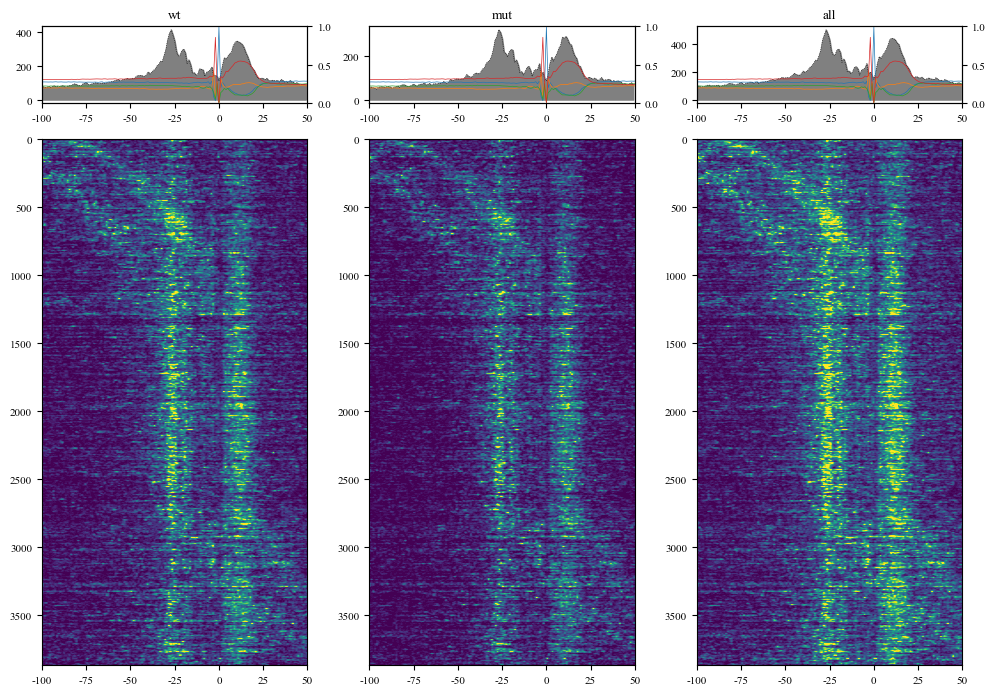

In [23]:
plt.rcParams["figure.figsize"] = (10,7)
xlim=[-100,50]
peak_range=[-100,0]
peak_width=20
n_sa={'all':5, 'wt':3, 'mut':2}
#norm_method='raw' 
norm_method='normalized'
#xlim=-15,5
for which,iclip_bw in iclip_bw_dict.items():
    for align in iclip_bw:
        fig = plt.figure()
        sel=iclip_bw[align]['all'].sum(1)>0
        # dists=[(i,d) for i,(s,d) in enumerate(zip(sel,bpdist.get(align, bpdist['BP_branchpointeR']))) if s]
        # order=[i for i,_ in sorted(dists, key=lambda x: x[1])]
        for i,what in enumerate(iclip_bw[align]):
            vals=iclip_bw[align][what].values[sel,slice(flanking+xlim[0], flanking+xlim[1])]
            #vals=iclip_bw[align][what].loc[order,slice(xlim[0], xlim[1])].values/n_sa[what]
            if norm_method!='raw':
                vals/=np.maximum(np.max(vals, axis=1),10)[:,None]
            #vals[vals>1]=1
            ax_profile = plt.subplot2grid((6,3), (0,i), colspan=1, rowspan=1, fig=fig)
            y=vals.sum(0)
            x=range(*xlim)
            ax_profile.plot( x,y,ls=':', color='black', lw=.5)
            ax_profile.fill_between(x, y, color='grey')
            ax_profile.set_xlim(*xlim)
            ax = plt.subplot2grid((6,3), (1,i), colspan=1, rowspan=5, fig=fig)

            im=ax.imshow(vals,norm=colors.Normalize(vmin=0, vmax=.2), cmap=cmap, 
                             aspect='auto',  interpolation='gaussian',extent=[*xlim,len(vals),0])
            
            ax_profile.set_title(what)
            ax_base = ax_profile.twinx()
            x=range(*xrange)
            base_profile=base_count[align][range(*xrange)]/ base_count[align][range(*xrange)].sum(0)
            for base in 'ACGT':
                ax_base.plot(x, base_profile.loc[base], label=base, lw=.5)
            ax_base.set_ylim(0,1)
            #ax_base.legend()
        #fig.colorbar(im, ax=axs[2])
        #extent=[-400,400,n-offset,0]
        fig.tight_layout()
        fig.savefig(f"{plot_path}/iCLIP_heatmap_3AS_{which}_fwd_{align}_{norm_method}_{tool}.pdf")
